In [33]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
import astroddpm
import tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 
import arviz as az

In [34]:
from cmb_hmc.cmb_ps import CMBPS, unnormalize_phi, normalize_phi
from cmb_hmc.hmc_torch import HMC

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 3

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [36]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [37]:
batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[:1]

In [38]:
theta_target = diffuser.diffmodel.ps.sample_theta(100).mean(dim = 0, keepdim=True).to(device)
ps = diffuser.diffmodel.ps(theta_target)
rtheta_target = diffuser.diffmodel.ps.rescale_theta(theta_target)
sq_ps = torch.sqrt(ps).to(device)
theta_target = theta_target.to(device)
noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, 100, sq_ps)

In [39]:
NUM_CHAIN = 16

In [40]:
batch = image.repeat(NUM_CHAIN, 1, 1, 1)
ps_0, thetas_0 = diffuser.diffmodel.ps.sample_ps(NUM_CHAIN)
batch_mean = mean.repeat(NUM_CHAIN, 1, 1, 1)
noisy_batch = noisy.repeat(NUM_CHAIN, 1, 1, 1)

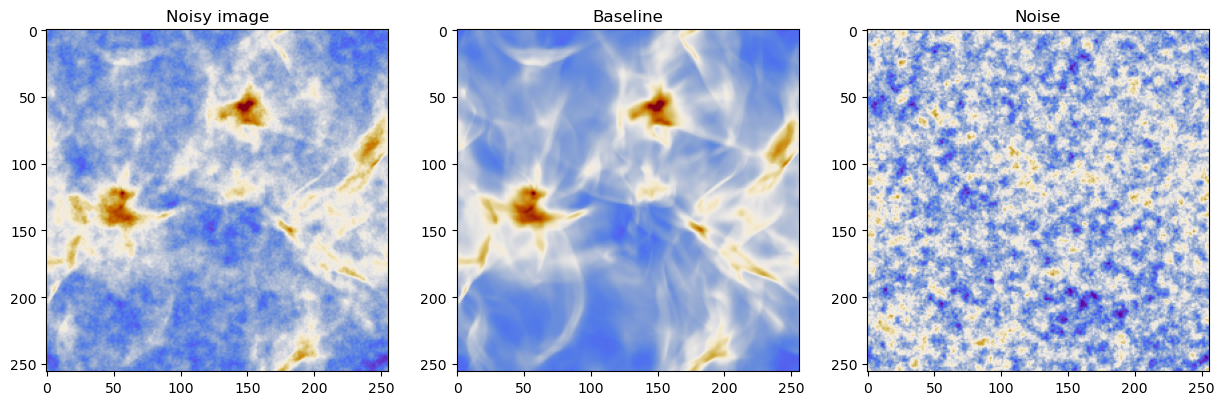

In [41]:
## Plot the noisy image along with the noise and baseline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[0].set_title('Noisy image')
ax[1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[1].set_title('Baseline')
ax[2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[2].set_title('Noise')
plt.show()

In [42]:
N_GIBBS = 300
BURNIN_HEURISTIC = 300
BURNIN_GIBBS = 100
N_HMC = 100

timesteps = 100 * torch.ones(NUM_CHAIN, dtype=torch.int32).to(device)

In [43]:
def sample_prior(n):
    """
    Sample from the (normalized) prior distribution.
    phi = (H0, Obh2) with H0 ~ U(0, 1), Obh2 ~ U(0, 1)
    (unnormalized prior is H0 ~ U(50, 90), Obh2 ~ U(0.0075, 0.0567))
    """
    phi = torch.rand(n, 2).to(device)
    return phi

ps_model = CMBPS(norm_phi=True).to(device)

In [44]:
def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2, -3)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2, -3))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi + term_logdet + term_x

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float())
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float())
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [45]:
theta_list = []
phi_list = []
rescaled_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)

In [46]:
thetas = thetas_0.clone().to(device)
progress_bar = tqdm.tqdm(range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC))
flag_optim_step_size = False
curr_step_size = 0
for n in range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC):
    X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, initial_timestep=100, verbose=False, thetas = thetas)
    ps = diffuser.diffmodel.ps(thetas)
    sq_ps = torch.sqrt(ps).to(device)
    _, mean, _ = diffuser.diffmodel.sde.sampling(X_0, 100, sq_ps)
    epsilon_hat = (rescaled_batch - mean)/diffuser.diffmodel.sde.noise_level(timesteps)
    log_prob = lambda phi: log_posterior(phi, epsilon_hat)
    def log_prob_grad(phi):
        """
        Compute the log posterior and its gradient.
        """
        log_prob = log_posterior(phi, epsilon_hat)
        grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
        return log_prob, grad_log_prob
    hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
    if n < BURNIN_HEURISTIC:
        kwargs = {'nsamples': 1,
          'burnin': 20,
          'step_size': 7.5e-6,
          'nleap': 5}
        epsadapt = 0
    else:
      if (phi-phi_0 == 0).all():
        print('HMC rejecting all')
        break
        kwargs = {'nsamples': 1,
          'burnin': 20,
          'step_size': curr_step_size/1.5,
          'nleap': 5}
        epsadapt = 0
      else:
        kwargs = {'nsamples': 1,
          'burnin': 20,
          'step_size': min(1e-5*100**((n-BURNIN_HEURISTIC)/BURNIN_GIBBS),2e-4),
          'nleap': 5}
        curr_step_size = min(1e-5*100**((n-BURNIN_HEURISTIC)/BURNIN_GIBBS),2e-4)
        epsadapt = 0

    phi_0 = sample_prior(NUM_CHAIN).requires_grad_().to(device)
    phi_0 = phi_list[-1].requires_grad_() if len(phi_list) > 0 else phi_0
    sampler = hmc.sample(phi_0, epsadapt = epsadapt, verbose = False, **kwargs)
    phi = sampler.samples[:,-1]
    if n < BURNIN_HEURISTIC:
      phi +=200*(0.985)**n*(phi-phi_0)
      
    phi_list.append(phi) 
    thetas = unnormalize_phi(phi)
    theta_list.append(thetas)
    thetas.detach()
    thetas.requires_grad_()
    thetas = thetas.to(device)
    progress_bar.update(1)
progress_bar.close()

 44%|████▍     | 309/700 [28:25<35:58,  5.52s/it]  

HMC rejecting all


In [47]:
0.989**200*200

21.892144955760973

In [48]:
tensor_phi_list = [phi.unsqueeze(0) for phi in phi_list]

In [49]:
tensor_phi_list = torch.cat(tensor_phi_list, dim=0)

In [50]:
tensor_phi_list.shape

torch.Size([309, 16, 2])

In [51]:
phi_test = normalize_phi(theta_target)

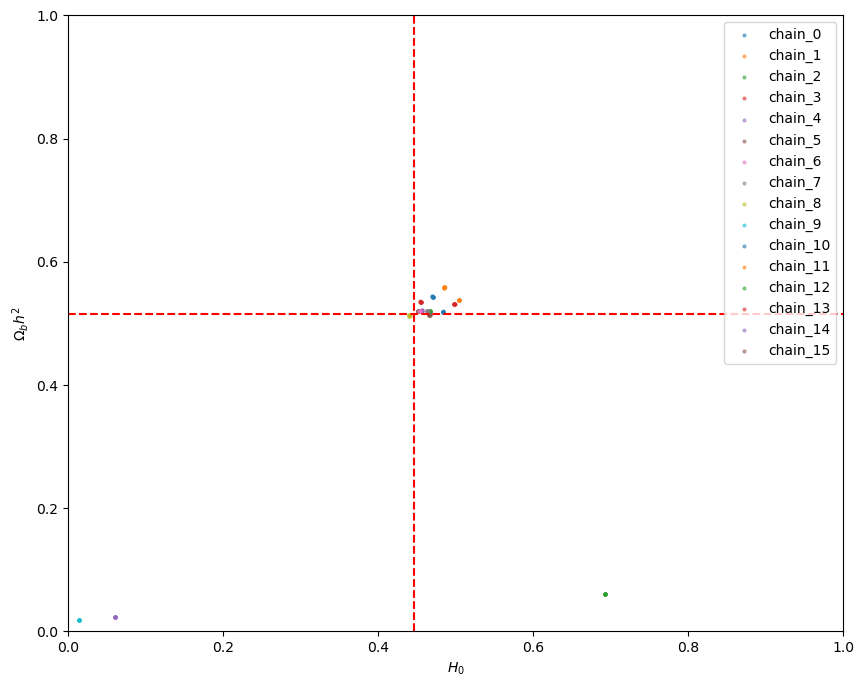

<Figure size 640x480 with 0 Axes>

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(tensor_phi_list.shape[1]):
    ax.scatter(tensor_phi_list[300:, i, 0].detach().cpu().numpy(), tensor_phi_list[300:,i, 1].detach().cpu().numpy(), s=4, alpha=0.5, label = 'chain_{}'.format(i))
ax.axvline(phi_test[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax.axhline(phi_test[0,1].detach().cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.savefig('phi.png')

In [53]:
interesting_chains = range(16)

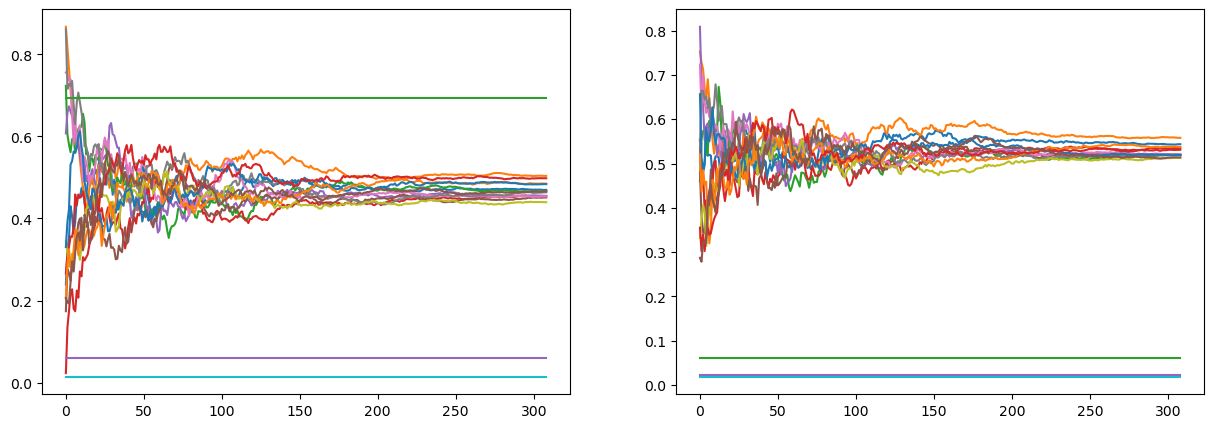

In [54]:
### Trace plots for these chains

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in interesting_chains:
    ax[0].plot(tensor_phi_list[:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax[1].plot(tensor_phi_list[:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))

In [55]:
chains = [tensor_phi_list[:, i, :].detach().cpu().numpy() for i in interesting_chains]
az_inf_data = az.convert_to_inference_data(tensor_phi_list.movedim(1,0)[:,:,:].cpu().detach().numpy())

In [56]:
ess, rhat = az.ess(az_inf_data), az.rhat(az_inf_data)

print(ess['x'].values, rhat['x'].values)

[21.3525277  23.05697406] [2.14125318 1.91863433]


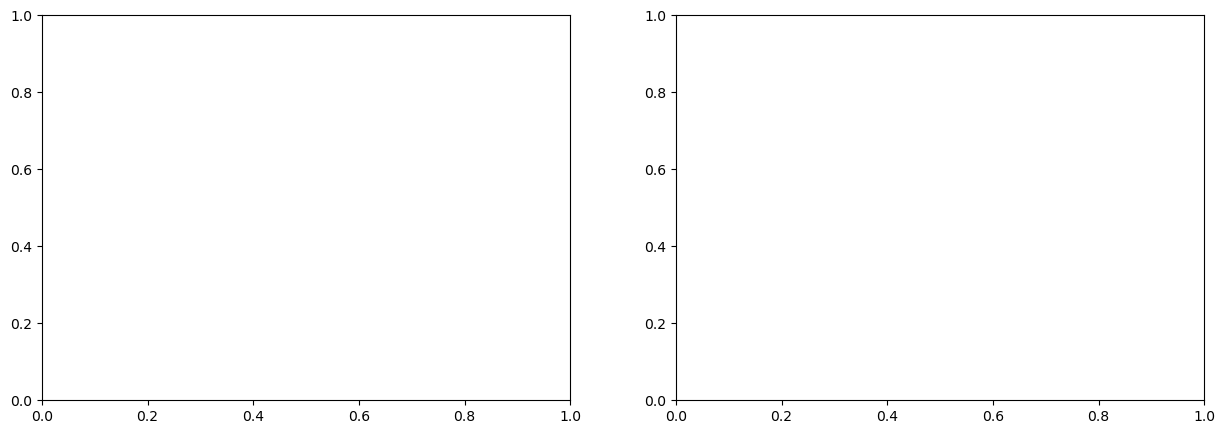

In [57]:
### Trace plots for all the other chains

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(tensor_phi_list.shape[1]):
    if i not in interesting_chains:
        ax[0].plot(tensor_phi_list[:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
        ax[1].plot(tensor_phi_list[:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))

Code for log likelihood landscaped plotting

In [58]:
def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi, term_logdet, term_x, term_x + term_logdet + term_pi

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float())
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float())
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [59]:
phi_0 = tensor_phi_list[0]
phi_target = normalize_phi(theta_target)

In [60]:
tensor_phi_list.shape

torch.Size([309, 16, 2])

In [61]:
idx = 6

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /dev/shm/nix-build-py-torch-2.0.1.drv-2/nixbld2/spack-stage-py-torch-2.0.1-mz6i5h51yxg23diix2nxgr73s62pzclc/spack-src/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


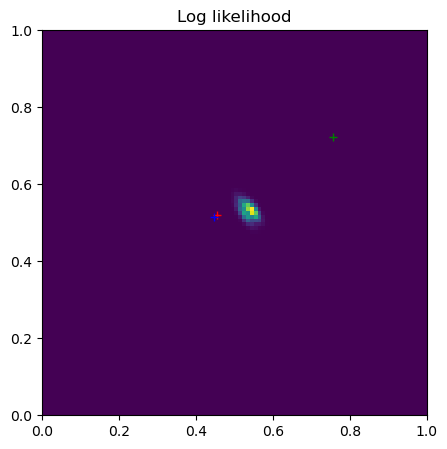

In [62]:
## Compute the log posterior for the observation and the first image on a grid of value for phi and plot it
H0 = torch.linspace(0, 1, 100)
Obh2 = torch.linspace(0, 1, 100)
H0_grid, Obh2_grid = torch.meshgrid(H0, Obh2)
phi_grid = torch.stack([H0_grid, Obh2_grid], dim=-1).to(device)
_, logdet_grid, logtermx_grid, log_likelihood_grid = log_likelihood(phi_grid.reshape(-1,2), epsilon_hat[idx:idx+1])
logdet_grid = logdet_grid.reshape(100, 100)
logtermx_grid = logtermx_grid.reshape(100, 100)
log_likelihood_grid = log_likelihood_grid.reshape(100, 100)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(np.exp(log_likelihood_grid.cpu().numpy()+24256.0732), extent=[0, 1, 0, 1])
ax.plot(tensor_phi_list[-1,idx,0].detach().cpu().numpy(), tensor_phi_list[-1,idx,1].detach().cpu().numpy(), color='r',marker = '+')
ax.plot(phi_0[idx,0].detach().cpu().numpy(), phi_0[idx,1].detach().cpu().numpy(), color='g',marker = '+')
ax.plot(phi_test[0,0].detach().cpu().numpy(), phi_test[0,1].detach().cpu().numpy(), color='b',marker = '+')
ax.set_title('Log likelihood')
# ax[1].imshow(logdet_grid.cpu().numpy(), extent=[0, 1, 0, 1])
# ax[1].set_title('Log determinant')
# ax[2].imshow(logtermx_grid.cpu().numpy(), extent=[0, 1, 0, 1])
# ax[2].set_title('Log term x')
plt.show()

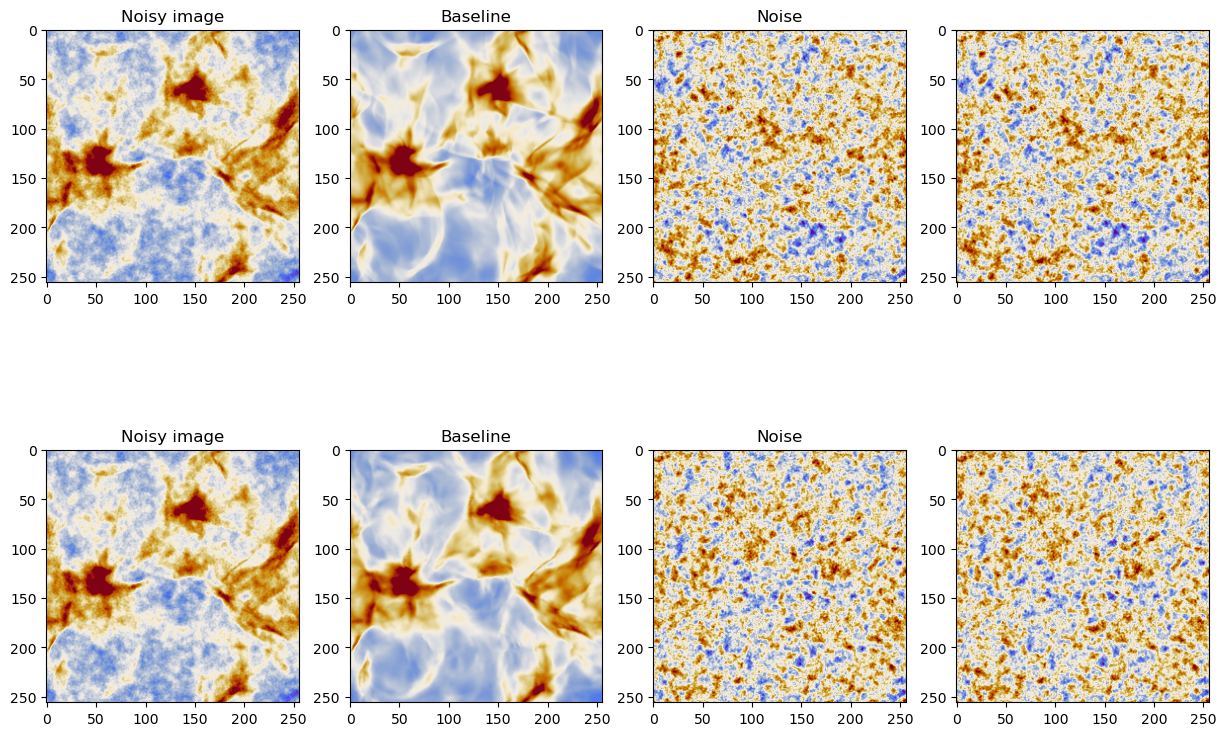

In [63]:
## Plot the noisy image along with the noise and baseline
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0,0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,0].set_title('Noisy image')
ax[0,1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,1].set_title('Baseline')
ax[0,2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,2].set_title('Noise')
ax[0,3].imshow(((diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy, timesteps)-batch)/diffuser.diffmodel.sde.noise_level(timesteps))[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)

ax[1,0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,0].set_title('Noisy image')
ax[1,1].imshow(X_0[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,1].set_title('Baseline')
ax[1,2].imshow(epsilon_hat[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,2].set_title('Noise')
ax[1,3].imshow(((diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy, timesteps)-X_0)/diffuser.diffmodel.sde.noise_level(timesteps))[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)

plt.show()